In [1]:
import torch
import numpy as np
import torch.nn.functional as F

/Users/lucasvanwalstijn/miniconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./names.txt') as file:
    names = file.read().splitlines()

In [3]:
names[:3]

['emma', 'olivia', 'ava']

### Let's try to get this generic block_size thing going:

In [4]:
block_size = 10
pointer = '-->'

for name in names[:3]:
    print('#' * (block_size + len(pointer) + 3))
    print(name)
    padded_name = '.' * block_size + name + '.'
    for i in range(len(name)+1):
        print(padded_name[i:i+block_size], pointer, padded_name[block_size+i])

################
emma
.......... --> e
.........e --> m
........em --> m
.......emm --> a
......emma --> .
################
olivia
.......... --> o
.........o --> l
........ol --> i
.......oli --> v
......oliv --> i
.....olivi --> a
....olivia --> .
################
ava
.......... --> a
.........a --> v
........av --> a
.......ava --> .


### After looking again at the video, Andrej does it with this `context` which is much cleaner

In [5]:
block_size = 10
pointer = '-->'

for name in names[:3]:
    print('#' * (block_size + len(pointer) + 3))
    print(name)
    context = '.' * block_size
    for ch in name + '.':
        print(context, pointer, ch)
        context = context[1:] + ch

################
emma
.......... --> e
.........e --> m
........em --> m
.......emm --> a
......emma --> .
################
olivia
.......... --> o
.........o --> l
........ol --> i
.......oli --> v
......oliv --> i
.....olivi --> a
....olivia --> .
################
ava
.......... --> a
.........a --> v
........av --> a
.......ava --> .


In [6]:
letters = sorted(set(letter for name in names for letter in name))

In [7]:
i_to_s = {i+1: s for i, s in enumerate(letters)}
i_to_s[0] = '.'
s_to_i = {s: i for i, s in i_to_s.items()}

### Now, let's create the dataset

In [8]:
BLOCK_SIZE = 3

X = []
Y = []

for name in names[:5]:
    context = '.' * BLOCK_SIZE
    for ch in name + '.':
        X.append([s_to_i[s] for s in context])
        Y.append(s_to_i[ch])
        context = context[1:] + ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
X.shape, X.dtype

(torch.Size([32, 3]), torch.int64)

In [10]:
Y.shape, Y.dtype

(torch.Size([32]), torch.int64)

## Now let's create the neural network step by step

### First, create the C matrix (the embedding matrix)

In [18]:
EMBEDDING_DIMENSION = 2

g = torch.Generator().manual_seed(42)

C = torch.randn([27,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

In [19]:
C

tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [-0.7521,  1.6487],
        [-0.3925, -1.4036],
        [-0.7279, -0.5594],
        [-0.7688,  0.7624],
        [ 1.6423, -0.1596],
        [-0.4974,  0.4396],
        [-0.7581,  1.0783],
        [ 0.8008,  1.6806],
        [ 1.2791,  1.2964],
        [ 0.6105,  1.3347],
        [-0.2316,  0.0418],
        [-0.2516,  0.8599],
        [-1.3847, -0.8712],
        [-0.2234,  1.7174],
        [ 0.3189, -0.4245],
        [-0.8140, -0.7360],
        [-0.8371, -0.9224],
        [ 1.8113,  0.1606],
        [ 0.3672,  0.1754],
        [-1.1845,  1.3835],
        [-1.2024,  0.7078],
        [-1.0759,  0.5357],
        [ 1.1754,  0.5612]], requires_grad=True)

In [20]:
X[0]

tensor([0, 0, 0])

In [21]:
C[X[0]]

tensor([[1.9269, 1.4873],
        [1.9269, 1.4873],
        [1.9269, 1.4873]], grad_fn=<IndexBackward>)

In [22]:
F.one_hot(torch.tensor(0), num_classes=27).float() @ C

tensor([1.9269, 1.4873], grad_fn=<SqueezeBackward3>)

In [23]:
X[1]

tensor([0, 0, 5])

In [24]:
C[X[1]]

tensor([[ 1.9269,  1.4873],
        [ 1.9269,  1.4873],
        [-0.3925, -1.4036]], grad_fn=<IndexBackward>)

In [25]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.3925, -1.4036], grad_fn=<SqueezeBackward3>)

In [26]:
C[X][0:2]

tensor([[[ 1.9269,  1.4873],
         [ 1.9269,  1.4873],
         [ 1.9269,  1.4873]],

        [[ 1.9269,  1.4873],
         [ 1.9269,  1.4873],
         [-0.3925, -1.4036]]], grad_fn=<SliceBackward>)

In [27]:
C[X].shape

torch.Size([32, 3, 2])

In [28]:
embeddings = C[X]

In [38]:
HIDDEN_LAYER_CAPACITY = 100

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY

g = torch.Generator().manual_seed(42)
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)

In [39]:
W1.shape

torch.Size([6, 100])

In [40]:
embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE).shape

torch.Size([32, 6])

In [41]:
z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1

In [42]:
z1.shape

torch.Size([32, 100])

In [43]:
a1 = z1.tanh()

In [44]:
a1

tensor([[ 0.9998,  0.9999,  0.7375,  ...,  0.5377,  0.9969,  0.9998],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.9483,  0.9976,  0.9999],
        [ 0.9982,  0.8478, -0.4886,  ...,  0.8920,  0.9896,  0.5183],
        ...,
        [-0.4413, -0.9998, -0.6653,  ..., -0.3774,  0.6519, -0.3608],
        [-0.9910,  0.8109, -0.9979,  ..., -0.3973, -0.3881, -0.2602],
        [ 0.9997,  0.9411,  0.9995,  ...,  0.4602,  0.9744,  0.1070]],
       grad_fn=<TanhBackward>)

In [45]:
g = torch.Generator().manual_seed(42)
W2 = torch.randn([HIDDEN_LAYER_CAPACITY, 27], requires_grad=True, generator=g)

In [46]:
z2 = a1 @ W2

In [47]:
z2.shape

torch.Size([32, 27])

In [48]:
loss = F.cross_entropy(z2, target=Y)

In [49]:
loss

tensor(21.5800, grad_fn=<NllLossBackward>)

In [50]:
softmax = F.log_softmax(z2, dim=1)

In [51]:
F.nll_loss(softmax, target=Y)

tensor(21.5800, grad_fn=<NllLossBackward>)

In [52]:
counts = z2.exp()

probs = counts / counts.sum(1, keepdim=True)

In [53]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [54]:
probs.shape

torch.Size([32, 27])

In [55]:
-probs[range(X.shape[0]), Y].log().mean()

tensor(21.5800, grad_fn=<NegBackward>)

### However, we forgot the biasses

In [72]:
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

embeddings = C[X]
z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
a1 = z1.tanh()
z2 = a1 @ W2 + b2

loss = F.cross_entropy(z2, target=Y)

In [73]:
loss

tensor(17.7697, grad_fn=<NllLossBackward>)

### Now let's add a gradient descent step

In [126]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100

In [127]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [134]:
# Forward pass
embeddings = C[X]
z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
a1 = z1.tanh()
z2 = a1 @ W2 + b2

loss = F.cross_entropy(z2, target=Y)


learning_rate = 1e-1
# Backward pass
loss.backward()
for pp in parameters:
    pp.data += - learning_rate * pp.grad
    pp.grad = None
loss

tensor(17.5560, grad_fn=<NllLossBackward>)

In [135]:
# Do another forward pass and check if gradient went down:

embeddings = C[X]
z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
a1 = z1.tanh()
z2 = a1 @ W2 + b2

loss = F.cross_entropy(z2, target=Y)

loss

tensor(13.5713, grad_fn=<NllLossBackward>)

### Reset and make training loop:

In [136]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [137]:
def forward():
    embeddings = C[X]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y)
    return loss
    
def backward(loss):
    loss.backward()
    
def step(learning_rate=1e-1):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad
        pp.grad = None

for i in range(10):
    loss = forward()
    print(loss)
    backward(loss)
    step()

tensor(17.7697, grad_fn=<NllLossBackward>)
tensor(13.6564, grad_fn=<NllLossBackward>)
tensor(11.2988, grad_fn=<NllLossBackward>)
tensor(9.4525, grad_fn=<NllLossBackward>)
tensor(7.9843, grad_fn=<NllLossBackward>)
tensor(6.8913, grad_fn=<NllLossBackward>)
tensor(6.1000, grad_fn=<NllLossBackward>)
tensor(5.4520, grad_fn=<NllLossBackward>)
tensor(4.8982, grad_fn=<NllLossBackward>)
tensor(4.4147, grad_fn=<NllLossBackward>)


### Looks good, let's run on all names

In [425]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100
BLOCK_SIZE = 3

In [426]:
X = []
Y = []

for name in names:
    context = '.' * BLOCK_SIZE
    for ch in name + '.':
        X.append([s_to_i[s] for s in context])
        Y.append(s_to_i[ch])
        context = context[1:] + ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [427]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [428]:
def forward():
    embeddings = C[X]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y)
    return loss
    
def backward(loss):
    loss.backward()
    
def step(learning_rate=1e-1):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad
        pp.grad = None

for i in range(200):
    loss = forward()
    if i%20 == 0:
        print(loss.item())
    backward(loss)
    step()

19.505855560302734
8.328840255737305
5.80296516418457
4.586923599243164
3.927968740463257
3.5757853984832764
3.356884717941284
3.2100067138671875
3.1046998500823975
3.0238876342773438


### Add minibatches

In [161]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100
BLOCK_SIZE = 3
BATCH_SIZE=1000

In [ ]:
X = []
Y = []

for name in names:
    context = '.' * BLOCK_SIZE
    for ch in name + '.':
        X.append([s_to_i[s] for s in context])
        Y.append(s_to_i[ch])
        context = context[1:] + ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [176]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [177]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    loss.backward()
    
def step(learning_rate=1e-1):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad
        pp.grad = None

for i in range(200):
    batch_indexs = torch.randint(0, X.shape[0], (BATCH_SIZE,))
    X_batch = X[batch_indexs]
    Y_batch = Y[batch_indexs]
    loss = forward(X_batch, Y_batch)
    if i%20 == 0:
        print(loss.item())
    backward(loss)
    step()

19.74472999572754
8.352926254272461
5.629281044006348
4.737269401550293
3.9773926734924316
3.4474387168884277
3.2276084423065186
3.3635058403015137
3.1907272338867188
3.0709846019744873


### Find good learning rate

In [220]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100
BLOCK_SIZE = 3
BATCH_SIZE=32

In [221]:
X = []
Y = []

for name in names:
    context = '.' * BLOCK_SIZE
    for ch in name + '.':
        X.append([s_to_i[s] for s in context])
        Y.append(s_to_i[ch])
        context = context[1:] + ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [222]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [223]:
1e-3

0.001

In [224]:
lre = np.linspace(-3, 0, 10)

lrs = [10**e for e in lre]

for x,y in zip(lre, lrs):
    print('exponent = %.4f, lr = %.4f' % (x, y))

exponent = -3.0000, lr = 0.0010
exponent = -2.6667, lr = 0.0022
exponent = -2.3333, lr = 0.0046
exponent = -2.0000, lr = 0.0100
exponent = -1.6667, lr = 0.0215
exponent = -1.3333, lr = 0.0464
exponent = -1.0000, lr = 0.1000
exponent = -0.6667, lr = 0.2154
exponent = -0.3333, lr = 0.4642
exponent = 0.0000, lr = 1.0000


In [225]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    loss.backward()
    
def step(learning_rate=1e-1):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad
        pp.grad = None

steps = 1000
lre = np.linspace(-3, 0, steps)
lrs = [10**e for e in lre]

loss_i = []

for i in range(steps):
    batch_indexs = torch.randint(0, X.shape[0], (BATCH_SIZE,))
    X_batch = X[batch_indexs]
    Y_batch = Y[batch_indexs]
    loss = forward(X_batch, Y_batch)
    loss_i.append(loss.item())
    backward(loss)
    step(lrs[i])

In [226]:
import matplotlib.pyplot as plt
%matplotlib inline

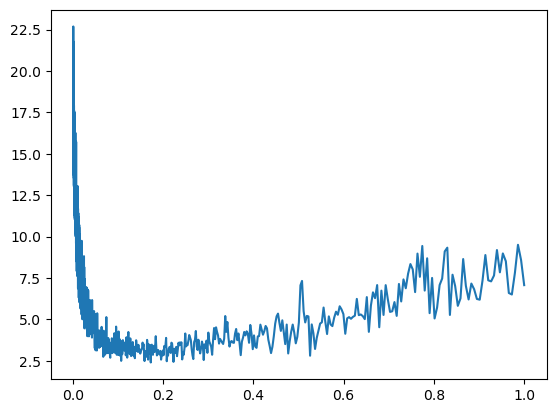

In [227]:
plt.plot(lrs, loss_i)

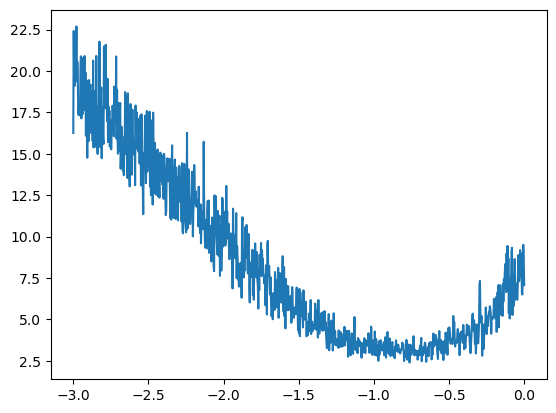

In [228]:
plt.plot(lre, loss_i)

### Train the model with learning rate decay

In [258]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100
BLOCK_SIZE = 3
BATCH_SIZE=32

In [259]:
X = []
Y = []

for name in names:
    context = '.' * BLOCK_SIZE
    for ch in name + '.':
        X.append([s_to_i[s] for s in context])
        Y.append(s_to_i[ch])
        context = context[1:] + ch
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [272]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [273]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    loss.backward()
    
def step(learning_rate):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad
        pp.grad = None

steps_arr = [30000, 10000]
lrs_arr = [1e-1, 1e-2]

for steps, lr in zip(steps_arr, lrs_arr):
    for i in range(steps):
        batch_indexs = torch.randint(0, X.shape[0], (BATCH_SIZE,))
        X_batch = X[batch_indexs]
        Y_batch = Y[batch_indexs]
        loss = forward(X_batch, Y_batch)
        backward(loss)
        step(lr)

In [274]:
forward(X, Y)

tensor(2.3328, grad_fn=<NllLossBackward>)

### Train / val / test set

In [306]:
def build_dataset(names):

    X = []
    Y = []

    for name in names:
        context = '.' * BLOCK_SIZE
        for ch in name + '.':
            X.append([s_to_i[s] for s in context])
            Y.append(s_to_i[ch])
            context = context[1:] + ch

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y


train_size = 0.8
val_size = 0.1

import random
random.seed(42)
random.shuffle(names)

train_names = names[0:int(train_size * len(names))]
val_names = names[int(train_size * len(names)): int((train_size + val_size) * len(names))]
test_names = names[int((train_size + val_size) * len(names)):]

In [307]:
len(names), len(train_names), len(val_names), len(test_names)

(32033, 25626, 3203, 3204)

In [308]:
assert len(names) == len(train_names) + len(val_names) + len(test_names)

In [309]:
X_train, Y_train = build_dataset(train_names)
X_val, Y_val = build_dataset(val_names)
X_test, Y_test = build_dataset(test_names)

In [310]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 100
BLOCK_SIZE = 3
BATCH_SIZE=32

In [311]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [312]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    for pp in parameters:
        pp.grad = None
    loss.backward()
    
def step(learning_rate):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad

steps_arr = [30000, 10000]
lrs_arr = [1e-1, 1e-2]

for steps, lr in zip(steps_arr, lrs_arr):
    for i in range(steps):
        batch_indexs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
        X_batch = X_train[batch_indexs]
        Y_batch = Y_train[batch_indexs]
        loss = forward(X_batch, Y_batch)
        backward(loss)
        step(lr)

In [313]:
forward(X_train, Y_train)

tensor(2.3337, grad_fn=<NllLossBackward>)

In [314]:
forward(X_val, Y_val)

tensor(2.3314, grad_fn=<NllLossBackward>)

### Experiment with larger hidden layer size

In [316]:
# Hyperparameters
EMBEDDING_DIMENSION = 2
HIDDEN_LAYER_CAPACITY = 300
BLOCK_SIZE = 3
BATCH_SIZE=32

In [325]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [326]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    for pp in parameters:
        pp.grad = None
    loss.backward()
    
def step(learning_rate):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad

steps_arr = [90000, 60000]
lrs_arr = [1e-1, 1e-2]

for steps, lr in zip(steps_arr, lrs_arr):
    for i in range(steps):
        batch_indexs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
        X_batch = X_train[batch_indexs]
        Y_batch = Y_train[batch_indexs]
        loss = forward(X_batch, Y_batch)
        backward(loss)
        step(lr)

In [327]:
forward(X_train, Y_train)

tensor(2.2290, grad_fn=<NllLossBackward>)

In [328]:
forward(X_val, Y_val)

tensor(2.2384, grad_fn=<NllLossBackward>)

### Visualize Embeddings

In [335]:
C

tensor([[ 0.4623, -0.1752],
        [-0.0218, -0.3549],
        [ 0.4278,  0.7490],
        [ 0.2933,  0.3108],
        [ 0.0432,  0.3645],
        [-0.3933, -0.5042],
        [ 0.2373,  0.6793],
        [ 0.3319,  0.9517],
        [-0.1584,  0.2209],
        [-0.7492, -0.2782],
        [-0.2175,  0.4480],
        [ 0.0875,  0.3474],
        [-0.3201,  0.9688],
        [-0.0256,  0.5800],
        [-0.5859,  0.2291],
        [-0.1509, -0.6513],
        [ 0.3412,  0.4137],
        [-1.4245,  0.4465],
        [-0.4368,  0.4975],
        [ 0.0666,  0.1633],
        [ 0.1442,  0.2099],
        [ 0.5272,  1.5231],
        [ 0.0464,  0.7406],
        [-0.2902,  0.3068],
        [-0.1150,  0.1304],
        [-1.1420, -0.0895],
        [-0.0966,  0.3462]], requires_grad=True)

In [350]:
C[1,0]

tensor(-0.0218, grad_fn=<SelectBackward>)

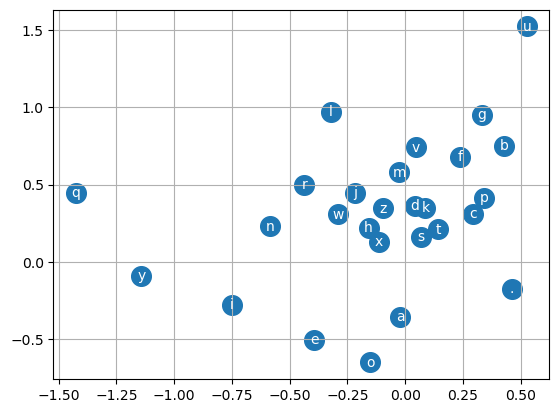

In [357]:
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].data, C[i,1].data, i_to_s[i], c='white', ha='center', va='center')
plt.grid('minor')

### Try out larger embedding size

In [358]:
# Hyperparameters
EMBEDDING_DIMENSION = 10
HIDDEN_LAYER_CAPACITY = 300
BLOCK_SIZE = 3
BATCH_SIZE=32

In [359]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [360]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    for pp in parameters:
        pp.grad = None
    loss.backward()
    
def step(learning_rate):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad

steps_arr = [90000, 60000]
lrs_arr = [1e-1, 1e-2]

for steps, lr in zip(steps_arr, lrs_arr):
    for i in range(steps):
        batch_indexs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
        X_batch = X_train[batch_indexs]
        Y_batch = Y_train[batch_indexs]
        loss = forward(X_batch, Y_batch)
        backward(loss)
        step(lr)

In [361]:
forward(X_train, Y_train)

tensor(2.1367, grad_fn=<NllLossBackward>)

In [362]:
forward(X_val, Y_val)

tensor(2.1734, grad_fn=<NllLossBackward>)

### Sampling from the model

In [400]:
g = torch.Generator().manual_seed(2147483647 + 10)


for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        embeddings = C[torch.tensor(context)]
        z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
        a1 = z1.tanh()
        z2 = a1 @ W2 + b2
        probs = F.softmax(z2, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([i_to_s[i] for i in out]))

jamea.
utzamellia.
makialayn.
yuma.
mil.
kiar.
bri.
krindur.
ajbera.
greque.
daiah.
tyn.
jery.
leightto.
lamaikladaliyah.
relle.
yea.
dylee.
biam.
hasymer.


## larger blocksize

In [410]:
# Hyperparameters
EMBEDDING_DIMENSION = 5
HIDDEN_LAYER_CAPACITY = 200
BLOCK_SIZE = 5
BATCH_SIZE = 1000

In [415]:
def build_dataset(names):

    X = []
    Y = []

    for name in names:
        context = '.' * BLOCK_SIZE
        for ch in name + '.':
            X.append([s_to_i[s] for s in context])
            Y.append(s_to_i[ch])
            context = context[1:] + ch

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y


train_size = 0.8
val_size = 0.1

import random
random.seed(42)
random.shuffle(names)

train_names = names[0:int(train_size * len(names))]
val_names = names[int(train_size * len(names)): int((train_size + val_size) * len(names))]
test_names = names[int((train_size + val_size) * len(names)):]

X_train, Y_train = build_dataset(train_names)
X_val, Y_val = build_dataset(val_names)
X_test, Y_test = build_dataset(test_names)

In [416]:
RAW_INPUT = len(i_to_s)

g = torch.Generator().manual_seed(2147483647)

C = torch.randn([RAW_INPUT,EMBEDDING_DIMENSION], requires_grad=True, generator=g)

w1_rows = EMBEDDING_DIMENSION * BLOCK_SIZE
w1_cols = HIDDEN_LAYER_CAPACITY
W1 = torch.randn([w1_rows, w1_cols], requires_grad=True, generator=g)
b1 = torch.randn([1, w1_cols], requires_grad=True, generator=g)

w2_rows = HIDDEN_LAYER_CAPACITY
w2_cols = RAW_INPUT
W2 = torch.randn([w2_rows, w2_cols], requires_grad=True, generator=g)
b2 = torch.randn([1, w2_cols], requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

In [417]:
def forward(X_batch, Y_batch):
    embeddings = C[X_batch]
    z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
    a1 = z1.tanh()
    z2 = a1 @ W2 + b2
    loss = F.cross_entropy(z2, target=Y_batch)
    return loss
    
def backward(loss):
    for pp in parameters:
        pp.grad = None
    loss.backward()
    
def step(learning_rate):
    for pp in parameters:
        pp.data += - learning_rate * pp.grad

steps_arr = [90000, 60000]
lrs_arr = [1e-1, 1e-2]

for steps, lr in zip(steps_arr, lrs_arr):
    for i in range(steps):
        batch_indexs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
        X_batch = X_train[batch_indexs]
        Y_batch = Y_train[batch_indexs]
        loss = forward(X_batch, Y_batch)
        backward(loss)
        step(lr)

In [418]:
forward(X_train, Y_train)

tensor(2.1734, grad_fn=<NllLossBackward>)

In [419]:
forward(X_val, Y_val)

tensor(2.1870, grad_fn=<NllLossBackward>)

In [420]:
g = torch.Generator().manual_seed(2147483647 + 10)


for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        embeddings = C[torch.tensor(context)]
        z1 = embeddings.view(-1, EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1
        a1 = z1.tanh()
        z2 = a1 @ W2 + b2
        probs = F.softmax(z2, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([i_to_s[i] for i in out]))

jamaa.
utkar.
alia.
makial.
radyn.
zamil.
kirrie.
dillind.
ganin.
catri.
queth.
iaili.
parelyn.
laevito.
lamaika.
zaleyland.
rauny.
abdylin.
bivmah.
mymor.
